# Recommendation System

#### Техническое задание:
- Порекомендовать по 5 товаров каждому пользователю, включая новых
- precision@5 за 3 следующие недели должен быть > 0.25

#### Я буду строить 2-ух уровненвую систему рекомендаций
- Модель 1-го уровня: Matcher, чтобы отобрать товары (кандидатов) для модели 2-го уровня
- Модель 2-го уровня: Ranker, это классификатор. Так как он точнее, метрика будет лучше. Но он не может обработать n * m * k количество данных, где n это колличество пользователей, m это количество товаров, а k это количество признаков. Поэтому мы сначала отбираем какое-то количество товаров (кандидатов) меньше m. По сути модель 2-го уровня будет менять порядок рекомендаций модели 1-го уровня и выбирать top-k товаров.

### Import libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Модели второго уровня
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Написанные мною функции (смотреть functions.ipynb)
from functions.metrics import precision_at_k, recall_at_k
from functions.utils import Prefilter_Items
from functions.recommenders import MainRecommender

### Random State

In [2]:
RANDOM_STATE = 1

### Read data

In [3]:
data = pd.read_csv('data/retail_train.csv') # Данные за предыдущие 95 недель

In [4]:
data.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.60,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.00,1631,1,0.0,0.0
2,2375,26984851472,1,1036325,1,0.99,364,-0.30,1631,1,0.0,0.0
3,2375,26984851472,1,1082185,1,1.21,364,0.00,1631,1,0.0,0.0
4,2375,26984851472,1,8160430,1,1.50,364,-0.39,1631,1,0.0,0.0


In [5]:
data.shape

(2396804, 12)

In [6]:
ITEM_COL = 'item_id'
USER_COL = 'user_id'
QUANTITY_COL = 'quantity'
WEEK_NO = 'week_no'

### EDA data

#### Пропуски

In [7]:
data.isna().sum().sum()

0

#### Типы данных

In [8]:
data.dtypes

user_id                int64
basket_id              int64
day                    int64
item_id                int64
quantity               int64
sales_value          float64
store_id               int64
retail_disc          float64
trans_time             int64
week_no                int64
coupon_disc          float64
coupon_match_disc    float64
dtype: object

#### Выбросы

In [9]:
data.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06,2.396804e+06
mean,1.271904e+03,3.336643e+10,3.639770e+02,2.827247e+06,1.003763e+02,3.100821e+00,3.048227e+03,-5.400708e-01,1.561714e+03,5.268156e+01,-1.638696e-02,-2.897905e-03
std,7.265644e+02,4.284798e+09,1.759385e+02,3.732798e+06,1.152379e+03,4.210229e+00,8.785542e+03,1.245824e+00,4.015691e+02,2.513310e+01,2.168615e-01,3.974618e-02
min,1.000000e+00,2.698485e+10,1.000000e+00,2.567100e+04,0.000000e+00,0.000000e+00,1.000000e+00,-1.300200e+02,0.000000e+00,1.000000e+00,-5.593000e+01,-7.700000e+00
25%,6.550000e+02,3.008714e+10,2.160000e+02,9.169930e+05,1.000000e+00,1.290000e+00,3.300000e+02,-6.900000e-01,1.307000e+03,3.200000e+01,0.000000e+00,0.000000e+00
50%,1.271000e+03,3.241998e+10,3.660000e+02,1.027569e+06,1.000000e+00,2.000000e+00,3.700000e+02,-2.000000e-02,1.614000e+03,5.300000e+01,0.000000e+00,0.000000e+00
75%,1.914000e+03,3.514580e+10,5.150000e+02,1.132178e+06,1.000000e+00,3.490000e+00,4.220000e+02,0.000000e+00,1.844000e+03,7.400000e+01,0.000000e+00,0.000000e+00
max,2.500000e+03,4.165679e+10,6.630000e+02,1.802456e+07,8.963800e+04,8.400000e+02,3.428000e+04,3.990000e+00,2.359000e+03,9.500000e+01,0.000000e+00,0.000000e+00


Видно, что есть данные, где:
- quantity = 0
- sales_value = 0
- quantity намного больше среднего
- sales_value намного больше среднего

In [10]:
data[data['quantity']==0].head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
97,744,26985165432,1,5978648,0,0.0,31582,0.0,1119,1,0.0,0.0
128,1287,26985336468,1,5978648,0,0.0,304,0.0,1351,1,0.0,0.0
249,2305,26996870743,2,5978656,0,0.0,414,0.0,1300,1,-1.0,0.0
293,271,26997082949,2,5978656,0,0.0,329,0.0,1719,1,-2.0,0.0
694,315,27008952267,3,957951,0,0.0,327,0.0,1707,1,0.0,0.0


quantity = 0 быть не может, скорее всего это отмена покупки

In [11]:
data = data[(data['quantity'] != 0)]

sales_value = 0 может быть, например если покупатель выбрал себе бонусный товар за покупку другово товара

In [12]:
data[data['quantity']>40000]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
156049,1406,28167562655,99,6544236,41485,85.00,327,-4.15,2015,15,0.0,0.0
166536,149,28210551971,103,6534178,51912,110.00,327,-5.19,1514,15,0.0,0.0
376686,149,29035716247,158,6534178,41686,100.00,327,-4.17,1310,23,0.0,0.0
468356,2407,29392047893,181,6544236,85055,210.00,375,-8.51,1606,27,0.0,0.0
481876,630,29484790880,185,6534178,61335,150.21,384,-6.13,1056,27,0.0,0.0
1340882,193,32956767959,402,6534178,48073,121.10,310,-7.21,1825,58,0.0,0.0
1560340,149,33768630428,456,6534178,41833,115.00,327,-4.18,1059,66,0.0,0.0
1750942,630,34749153595,503,6534178,89638,250.00,384,-13.45,1927,73,0.0,0.0


In [13]:
data[data['item_id']==6534178].head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
5378,932,27115512637,12,6534178,995,2.18,422,-0.01,1745,2,0.0,0.0
5380,932,27115512702,12,6534178,1461,3.20,422,-0.01,1757,2,0.0,0.0
6213,778,27130432788,13,6534178,2416,5.00,310,-0.24,1838,3,0.0,0.0
6674,778,27130955980,14,6534178,2728,6.00,422,-0.27,1222,3,0.0,0.0
7198,778,27153895714,15,6534178,8737,20.00,310,-0.01,1147,3,0.0,0.0


Видно, что просто есть несколько товар, которые покупают именно в большом количестве. Причём, чем больше покупают, тем дороже выходит. Значит всё нормально.

In [14]:
data[data['sales_value']>400]

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
526495,2080,29712930072,196,1089093,1,430.00,343,0.0,1929,29,0.0,0.0
547657,125,30031850855,201,1089093,1,455.00,323,0.0,1059,29,0.0,0.0
655985,125,30515165970,230,1089093,2,505.00,323,0.0,1231,34,0.0,0.0
1085442,1609,32006114302,339,12484608,3,840.00,412,0.0,2038,49,0.0,0.0
1152895,374,32187143334,355,13212959,1,499.99,361,-50.0,1740,51,0.0,0.0
2030766,346,40387571385,574,948670,5,631.80,415,0.0,1312,83,0.0,0.0


In [15]:
data[data['item_id']==1089093].head(10)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
3600,64,27093315740,10,1089093,1,400.00,372,0.0,957,2,0.0,0.0
234092,253,28511485096,120,1089093,1,20.00,441,0.0,738,18,0.0,0.0
384282,447,29094945928,160,1089093,1,82.00,286,0.0,2036,24,0.0,0.0
519536,1510,29702081266,195,1089093,1,142.27,414,0.0,1546,29,0.0,0.0
519655,1003,29702101753,195,1089093,2,190.00,295,0.0,1827,29,0.0,0.0
526495,2080,29712930072,196,1089093,1,430.00,343,0.0,1929,29,0.0,0.0
547657,125,30031850855,201,1089093,1,455.00,323,0.0,1059,29,0.0,0.0
655985,125,30515165970,230,1089093,2,505.00,323,0.0,1231,34,0.0,0.0
746691,1510,30822120156,255,1089093,5,138.00,414,0.0,842,37,0.0,0.0
864800,249,31198056289,284,1089093,3,246.60,289,0.0,1554,41,0.0,0.0


Видно, что цена сильно меняется, но в среднем она высокая на этот товар. Значит можно предположить, что как и в предыдущем случае, просто есть несколько товаров, которые именно много стоят.

### Split dataset for train and val, matcher and ranker

In [16]:
# -- train_matcher -- | -- val_matcher and train_ranker -- | -- val_ranker -- 

# Пускай:
VAL_MATCHER_WEEKS = 6
VAL_RANKER_WEEKS = 3

# Нужно будет подобрать размер 2-ого датасета --> иследовать зависимость метрики recall@k от размера датасета

# -- давние покупки -- | -- 6 недель -- | -- 3 недели -- 

In [17]:
# берем данные для тренировки matching модели
data_train_matcher = data[data[WEEK_NO] < data[WEEK_NO].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)]

# берем данные для валидации matching модели
data_val_matcher = data[(data[WEEK_NO] >= data[WEEK_NO].max() - (VAL_MATCHER_WEEKS + VAL_RANKER_WEEKS)) &
                      (data[WEEK_NO] < data[WEEK_NO].max() - (VAL_RANKER_WEEKS))]


# берем данные для тренировки ranking модели
data_train_ranker = data_val_matcher.copy()  

# берем данные для валидации ranking модели
data_val_ranker = data[data[WEEK_NO] >= data[WEEK_NO].max() - VAL_RANKER_WEEKS]

# train
data_train = pd.concat([data_train_matcher, data_val_matcher])

In [18]:
def print_stats_data(df_data, name_df):
    print(name_df)
    print(f"Shape: {df_data.shape} Users: {df_data[USER_COL].nunique()} Items: {df_data[ITEM_COL].nunique()}")

In [19]:
print_stats_data(data_train_matcher,'train_matcher')
print_stats_data(data_val_matcher,'val_matcher')
print_stats_data(data_train_ranker,'train_ranker')
print_stats_data(data_val_ranker,'val_ranker')

train_matcher
Shape: (2097300, 12) Users: 2498 Items: 83404
val_matcher
Shape: (168496, 12) Users: 2154 Items: 27540
train_ranker
Shape: (168496, 12) Users: 2154 Items: 27540
val_ranker
Shape: (117646, 12) Users: 2042 Items: 24270


Выше видим разброс по пользователям и товарам и дальше мы перейдем к warm-start (только известные пользователи) для выбора модели matcher и выбора количества претендетов, в остальных случаях на каждом этапе для новых пользователей мы будем рекомендовать top-n товары.

In [20]:
data_train_matcher.head(2)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,2375,26984851472,1,1004906,1,1.39,364,-0.6,1631,1,0.0,0.0
1,2375,26984851472,1,1033142,1,0.82,364,0.0,1631,1,0.0,0.0


### Prefilter items

In [21]:
n_items_train_before = data_train_matcher[ITEM_COL].nunique()
n_users_train_before = data_train_matcher[USER_COL].nunique()

# Возьмём топ-n товаров для выбора кандидатов
# Пускай:
N_TOP = 5000

# Нужно будет подобрать количество топ товаров --> иследовать зависимость метрики recall@k от количества топ товаров

prefilter_items = Prefilter_Items(drop_not_top_N=N_TOP)
prefilter_items.fit(data_train_matcher)
data_train_matcher = prefilter_items.transform(data_train_matcher)

n_items_train_after = data_train_matcher[ITEM_COL].nunique()
n_users_train_after = data_train_matcher[USER_COL].nunique()

print('Decreased # items on train from {} to {}'.format(n_items_train_before, n_items_train_after))
print('Decreased # users on train from {} to {}'.format(n_users_train_before, n_users_train_after))

Decreased # items on train from 83404 to 5000
Decreased # users on train from 2498 to 2475


### Make cold-start to warm-start for select Matcher model

In [22]:
# общие пользователи
common_users_matcher = list( set(data_train_matcher.user_id.values) & set(data_val_matcher.user_id.values) )

data_val_matcher = data_val_matcher[data_val_matcher.user_id.isin(common_users_matcher)]

print_stats_data(data_val_matcher,'val_matcher')

val_matcher
Shape: (167747, 12) Users: 2138 Items: 26983


### Создадим сет с реальными покупками пользователей

In [23]:
ACTUAL_COL = 'actual' # столбец с реальными покупками пользователей

In [24]:
result_eval_matcher = data_val_matcher.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_eval_matcher.columns=[USER_COL, ACTUAL_COL]
result_eval_matcher.head(2)

,user_id,actual
0,1,"[853529, 865456, 867607, 872137, 874905, 87524..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870..."


### Select parametrs ALS model (factors)

Зависимость recall@k от factors

Нужно получить наибольший recall@k. Так как задача модели 1-го уровня отобрать кандидатов для модели 2-го уровня среди которых будем максимальное количество купленных товаров.

In [25]:
# Пускай:
N_CHALLENG = 50 

# Нужно будет подобрать количество кандидатов --> иследовать зависимость метрики recall@k от количества кандидатов

In [26]:
def get_als_recs_factors(users, df_data, factors, random_state=42,
                         ITEM_COL='item_id', USER_COL='user_id', QUANTITY_COL='quantity', N=50):
    model = MainRecommender(df_data, own_recommender=False, als_factors=factors, random_state=random_state,
                        ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, show_progress=False)
    return users.apply(lambda x: model.get_als_recommendations(x, N=N))

In [27]:
%%time

factors_list = [50, 100, 200, 400, 700, 1000]

als_rec_factors  = [get_als_recs_factors(result_eval_matcher[USER_COL], data_train_matcher, factors, random_state=RANDOM_STATE,
                ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, N=N_CHALLENG) for factors in factors_list]

als_recall_factors = [np.array([recall_at_k(rec[i], result_eval_matcher[ACTUAL_COL][i], 
                                    k=N_CHALLENG) for i in result_eval_matcher.index]).mean() for rec in als_rec_factors]

list(zip(als_recall_factors, factors_list))

Wall time: 6min 45s


[(0.08489547405126797, 50),
 (0.09484807830177136, 100),
 (0.10732420175235481, 200),
 (0.11061417924367863, 400),
 (0.10982689339619801, 700),
 (0.10485793837447926, 1000)]

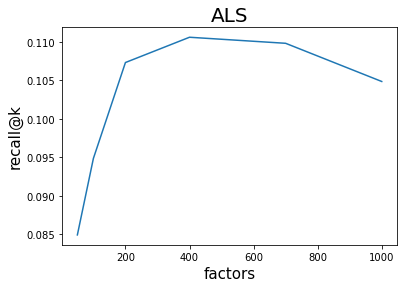

In [28]:
plt.plot(factors_list, als_recall_factors)
plt.title('ALS', fontsize=20)
plt.xlabel('factors', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

Видно, что метрика растёт до момента, когда factors = 400, дальше начинается переобучение.

#### Лучший recall@50, когда factors = 400.

In [29]:
N_FACTORS = 400

### Init/train recommender

In [30]:
recommender = MainRecommender(data_train_matcher, als_factors=N_FACTORS, random_state=RANDOM_STATE,
                             ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL)

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

### Select Matcher model

Попробуем различные варианты генерации кандидатов.

In [31]:
%%time
result_eval_matcher['als_rec'] = result_eval_matcher[USER_COL].apply(lambda x: 
                                                                recommender.get_als_recommendations(x, N=N_CHALLENG))
result_eval_matcher['own_rec'] = result_eval_matcher[USER_COL].apply(lambda x: 
                                                                recommender.get_own_recommendations(x, N=N_CHALLENG))
result_eval_matcher['sim_item_rec'] = result_eval_matcher[USER_COL].apply(lambda x: 
                                                                recommender.get_similar_items_recommendation(x, N=N_CHALLENG))
result_eval_matcher['baseline_top_n'] = [recommender.recs_top_n(N=N_CHALLENG)] * result_eval_matcher.shape[0]
# result_eval_matcher['sim_user_rec'] = result_eval_matcher[USER_COL].apply(lambda x: 
#                                                                recommender.get_similar_users_recommendation(x, N=N_CHALLENG))
# Эта модель долго рекомендует и она хуже чем als_rec, поэтому я её не запускаю, но при желании её можно тоже попробывать

Wall time: 3min


Пускай, если юзер купил < 50 товаров, то get_own_recommendations дополнит рекоммендации топ-популярными

In [32]:
def get_own_and_top_rec(own_rec, top_rec, N):
    return (own_rec + list(set(top_rec) - set(own_rec)))[:N]

In [33]:
result_eval_matcher['own_rec'] = result_eval_matcher['own_rec'].apply(lambda x: 
                                                get_own_and_top_rec(x, result_eval_matcher['baseline_top_n'][0], N_CHALLENG))

In [34]:
result_eval_matcher.head(8)

,user_id,actual,als_rec,own_rec,sim_item_rec,baseline_top_n
0,1,"[853529, 865456, 867607, 872137, 874905, 87524...","[1033142, 940631, 1105433, 1021164, 845078, 95...","[856942, 5577022, 9655212, 931136, 1124029, 80...","[981760, 833025, 1011459, 9526411, 1052046, 10...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
1,2,"[15830248, 838136, 839656, 861272, 866211, 870...","[833715, 1133018, 930118, 5569230, 957013, 911...","[826784, 1053924, 9365871, 1122085, 1113780, 9...","[1082627, 1000707, 913671, 1081479, 826249, 81...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
2,4,"[883932, 970760, 1035676, 1055863, 1097610, 67...","[891423, 951821, 822178, 883932, 1121367, 1115...","[891423, 910109, 887003, 1121367, 951821, 1115...","[7409664, 981760, 901762, 965766, 8119302, 826...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
3,6,"[1024306, 1102949, 6548453, 835394, 940804, 96...","[904360, 1055504, 878996, 919681, 1082185, 112...","[13003092, 9911484, 5569792, 1084036, 1119051,...","[981760, 889731, 1068292, 826249, 8181515, 102...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
4,7,"[836281, 843306, 845294, 914190, 920456, 93886...","[987724, 5591154, 861821, 828867, 889731, 8684...","[949836, 6944571, 6602729, 983316, 6533878, 11...","[981760, 859010, 1070214, 947068, 1038985, 825...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
5,8,"[868075, 886787, 945611, 1005186, 1008787, 101...","[1091365, 1082185, 1133018, 1068719, 833715, 8...","[1116578, 981660, 5577022, 1105433, 6463874, 8...","[981760, 833025, 1005186, 889731, 1101956, 982...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
6,9,"[883616, 1029743, 1039126, 1051323, 1082772, 1...","[862799, 1139471, 1056005, 952317, 5569303, 10...","[1056005, 862799, 1018588, 1090017, 1098910, 9...","[916993, 918018, 889731, 1056005, 826249, 8623...","[1082185, 981760, 995242, 1029743, 1127831, 10..."
7,13,"[6544236, 822407, 908317, 1056775, 1066289, 11...","[1022097, 1136257, 6534178, 8090521, 1110292, ...","[893802, 1038985, 862070, 1042942, 898466, 101...","[981760, 6533765, 1053063, 1038985, 971922, 11...","[1082185, 981760, 995242, 1029743, 1127831, 10..."


In [35]:
def calc_recall(df_data, top_k, ACTUAL_COL='actual'):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: recall_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

In [36]:
def calc_precision(df_data, top_k, ACTUAL_COL='actual'):
    for col_name in df_data.columns[2:]:
        yield col_name, df_data.apply(lambda row: precision_at_k(row[col_name], row[ACTUAL_COL], k=top_k), axis=1).mean()

### Recall@k of matching

In [37]:
TOPK_RECALL = 50

In [38]:
sorted(calc_recall(result_eval_matcher, TOPK_RECALL, ACTUAL_COL=ACTUAL_COL), key=lambda x: x[1],reverse=True)

[('als_rec', 0.11061417924367865),
 ('own_rec', 0.09259164455399503),
 ('baseline_top_n', 0.08856327081038104),
 ('sim_item_rec', 0.08025186659513837)]

У модели ALS лучше всех метрика recall@k

#### В качестве модели 1-го уровня выбираем ALS

Но это ещё не значит, что если бы мы рекомендовали только моделью 1-го уровня, то ALS это лучший выбор, так как нас бы интересовала метрика precision@k.

### Precision@k of matching

In [39]:
TOPK_PRECISION = 5

In [40]:
sorted(calc_precision(result_eval_matcher, TOPK_PRECISION, ACTUAL_COL=ACTUAL_COL), key=lambda x: x[1],reverse=True)

[('own_rec', 0.24041159962581624),
 ('baseline_top_n', 0.20523854069223293),
 ('als_rec', 0.1565949485500448),
 ('sim_item_rec', 0.08980355472404071)]

Если бы мы рекомендовали только моделью 1-го уровня, то мы бы выбрали модель own_rec.

### Select N_CHALLENG

Зависимость recall@k от k

In [41]:
%%time

K = [20, 50, 100, 200, 500]

als_rec_at_k  = [(result_eval_matcher[USER_COL].apply(lambda x: recommender.get_als_recommendations(x, N=k)), k) for k in K]

als_recall_at_k = [np.array([recall_at_k(rec[0][i], result_eval_matcher[ACTUAL_COL][i], 
                                    k=rec[1]) for i in result_eval_matcher.index]).mean() for rec in als_rec_at_k]

list(zip(als_recall_at_k, K))

Wall time: 3min 34s


[(0.057887195113334886, 20),
 (0.11061417924367863, 50),
 (0.16728700794824852, 100),
 (0.23592343973753002, 200),
 (0.32248118052715885, 500)]

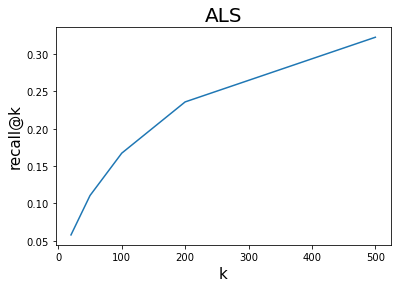

In [42]:
plt.plot(K, als_recall_at_k)
plt.title('ALS', fontsize=20)
plt.xlabel('k', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

recall@0 = 0

recall@N_TOP = 1

Чем больше k, чем больше потенциальных товаров (кандидатов) мы отбираем, тем модель второго уровня порекомендует точнее, но это будет дольше, так как количетво данных возрастёт до n * k, где n, это количетсво пользователей для которых мы рекомендуем.

Число k подбирается с учётом возможностей по мощности и времени ожидания.

Оптимальное число k находится на перегибе графика recall@k(k), там где стремтильный рост recall@k снижается. В нашем случае за перегиб можно взять точку k=200.

#### Оптимальное число кандидат для модели 2-го уровня = 200

In [43]:
N_CHALLENG = 200

### Top-n items

Найдём топ товаров для каждого этапа, чтобы рекомендовать их новым пользователям

In [44]:
def get_top_n(data, ITEM_COL='item_id', USER_COL='user_id', QUANTITY_COL='quantity', N=5):
        res = data.groupby(ITEM_COL)[QUANTITY_COL].count().reset_index()
        res.sort_values(QUANTITY_COL, ascending=False, inplace=True)
        res = res.item_id.head(N).tolist()
        return res

In [45]:
top_n_train_matcher = get_top_n(data_train_matcher, 
                                ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, N=N_CHALLENG)
top_n_train = get_top_n(data_train, ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, N=N_CHALLENG)
top_n_train_matcher[:5]

[1082185, 6534178, 1029743, 995242, 1106523]

### Подготовка данных для модели 2-го уровня

In [46]:
# взяли пользователей из data_train_ranker для ранжирования
df_match_candidates = pd.DataFrame(data_train_ranker[USER_COL].unique())
df_match_candidates.columns = [USER_COL]

In [47]:
# собираем кандитатов с первого этапа (matcher)
df_match_candidates['candidates'] = df_match_candidates[USER_COL].apply(lambda x: 
        recommender.get_als_recommendations(x, N=N_CHALLENG) if x in common_users_matcher else top_n_train_matcher)

In [48]:
df_match_candidates.head(2)

,user_id,candidates
0,2070,"[1077555, 1056509, 1082185, 897954, 1107553, 9..."
1,2021,"[948670, 1070702, 950935, 907014, 1074524, 102..."


In [49]:
df_items = df_match_candidates.apply(lambda x: pd.Series(x['candidates']), axis=1).stack().reset_index(level=1, drop=True)
df_items.name = ITEM_COL

In [50]:
df_match_candidates = df_match_candidates.drop('candidates', axis=1).join(df_items)

In [51]:
df_match_candidates.head(8)

,user_id,item_id
0,2070,1077555
0,2070,1056509
0,2070,1082185
0,2070,897954
0,2070,1107553
0,2070,981760
0,2070,1081177
0,2070,871756


### Создаем трейн сет для ранжирования с учетом кандидатов с этапа 1

In [52]:
# собираем данные о покупках с data_train_ranker
df_ranker_train = data_train_ranker[[USER_COL, ITEM_COL, 'quantity']].copy()
df_ranker_train.rename(columns={'quantity': 'target'}, inplace=True)
df_ranker_train = df_ranker_train.groupby([USER_COL, ITEM_COL]).count().reset_index()
df_ranker_train['target'] = df_ranker_train['target'].astype(bool).astype(int)
df_ranker_train.head(5)

,user_id,item_id,target
0,1,820165,1
1,1,829323,1
2,1,829563,1
3,1,830156,1
4,1,832990,1


In [53]:
# трейн сет для ранжирования
df_ranker_train = df_match_candidates.merge(df_ranker_train, on=[USER_COL, ITEM_COL], how='left')
df_ranker_train['target'].fillna(0, inplace=True)
df_ranker_train.head(5)

,user_id,item_id,target
0,2070,1077555,0.0
1,2070,1056509,0.0
2,2070,1082185,1.0
3,2070,897954,0.0
4,2070,1107553,0.0


In [54]:
df_ranker_train.target.value_counts()

0.0    399172
1.0     31628
Name: target, dtype: int64

In [55]:
disbalance = df_ranker_train.target.value_counts()[0] / df_ranker_train.target.value_counts()[1]
disbalance

12.620842291640319

Есть дизбаланс классов

### Подготавливаем признаки для обучения модели 2-го уровня

In [56]:
data_train_ranker.head(5)

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
2104867,2070,40618492260,594,1019940,1,1.00,311,-0.29,40,86,0.0,0.0
2107468,2021,40618753059,594,840361,1,0.99,443,0.00,101,86,0.0,0.0
2107469,2021,40618753059,594,856060,1,1.77,443,-0.09,101,86,0.0,0.0
2107470,2021,40618753059,594,869344,1,1.67,443,-0.22,101,86,0.0,0.0
2107471,2021,40618753059,594,896862,2,5.00,443,-2.98,101,86,0.0,0.0


### user

In [57]:
user_features = pd.read_csv('data/hh_demographic.csv') # Данные о пользователях

In [58]:
user_features.head(2)

,AGE_DESC,MARITAL_STATUS_CODE,INCOME_DESC,HOMEOWNER_DESC,HH_COMP_DESC,HOUSEHOLD_SIZE_DESC,KID_CATEGORY_DESC,household_key
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


In [59]:
user_features.shape

(801, 8)

In [60]:
# column processing
user_features.columns = [col.lower() for col in user_features.columns]

user_features.rename(columns={'household_key': USER_COL}, inplace=True) # household_key -> user_id

In [61]:
user_features.head(2)

,age_desc,marital_status_code,income_desc,homeowner_desc,hh_comp_desc,household_size_desc,kid_category_desc,user_id
0,65+,A,35-49K,Homeowner,2 Adults No Kids,2,None/Unknown,1
1,45-54,A,50-74K,Homeowner,2 Adults No Kids,2,None/Unknown,7


Проверим о скольких пользователях у нас есть данные:

In [62]:
(~df_ranker_train['user_id'].isin(user_features.user_id)).sum() # нет данных о пользователях

272600

In [63]:
df_ranker_train['user_id'].shape[0] # всего пользователей

430800

In [64]:
(~df_ranker_train['user_id'].isin(user_features.user_id)).sum() / df_ranker_train['user_id'].shape[0] * 100

63.27762302692664

Отсутствуют данные о 63% пользователей, по этому мы не будем использовать user_features который нам дан, но сделаем небольшой свой на основе имеющихся данных из data.

#### future engineering

#### Средний чек

In [65]:
average_check = (data_train_ranker.groupby([USER_COL])['sales_value'].sum() 
                                  / data_train_ranker.groupby([USER_COL])['basket_id'].nunique()).reset_index()

average_check.columns=[USER_COL, 'average_check']

my_user_features = average_check.copy()

#### Количество покупок в месяц

In [66]:
user_per_month = (data_train_ranker.groupby([USER_COL])['basket_id'].nunique() 
                                                  / ((VAL_MATCHER_WEEKS*7) / (365/12))).reset_index()

user_per_month.columns=[USER_COL, 'user_per_month']

my_user_features = my_user_features.merge(user_per_month, on=USER_COL, how='left')

In [67]:
my_user_features.head(2)

,user_id,average_check,user_per_month
0,1,48.825714,5.069444
1,2,47.572500,2.896825


### item

In [68]:
item_features = pd.read_csv('data/product.csv') # Данные о товарах

In [69]:
item_features.head(2)

,PRODUCT_ID,MANUFACTURER,DEPARTMENT,BRAND,COMMODITY_DESC,SUB_COMMODITY_DESC,CURR_SIZE_OF_PRODUCT
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


In [70]:
item_features.shape

(92353, 7)

In [71]:
# column processing
item_features.columns = [col.lower() for col in item_features.columns]

item_features.rename(columns={'product_id': ITEM_COL}, inplace=True) # product_id -> item_id

In [72]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,


Проверим о скольких товарах у нас есть данные:

In [73]:
(~df_ranker_train['item_id'].isin(item_features.item_id)).sum() # нет данных о товарах

0

Есть данные о всех товарах в трейн сете модели 2-го уровня.

### EDA item_features

#### Пропуски

In [74]:
item_features.isna().sum().sum()

0

#### Типы данных

In [75]:
item_features.dtypes

item_id                  int64
manufacturer             int64
department              object
brand                   object
commodity_desc          object
sub_commodity_desc      object
curr_size_of_product    object
dtype: object

#### Приведение типов и выбросы

manufacturer

In [76]:
item_features['manufacturer'].value_counts().head(20)

69      12676
2        1411
5423     1376
764      1332
1407     1210
693       979
544       915
5143      771
1046      717
1251      685
673       682
317       669
895       642
194       641
1628      589
103       535
177       532
958       526
857       512
1075      490
Name: manufacturer, dtype: int64

department

In [77]:
item_features['department'].value_counts().head(20)

GROCERY            39021
DRUG GM            31529
PRODUCE             3118
COSMETICS           3011
NUTRITION           2914
MEAT                2544
MEAT-PCKGD          2427
DELI                2354
PASTRY              2149
FLORAL               938
SEAFOOD-PCKGD        563
MISC. TRANS.         490
SPIRITS              377
SEAFOOD              369
GARDEN CENTER        128
RESTAURANT           102
MISC SALES TRAN       88
SALAD BAR             48
COUP/STR & MFG        39
TRAVEL & LEISUR       28
Name: department, dtype: int64

У нас есть 2 доминирующих класса и остальные.

In [78]:
item_features['department_GROCERY'] = (item_features['department'] == 'GROCERY').astype(int)
item_features['department_DRUG_GM'] = (item_features['department'] == 'DRUG GM').astype(int)
item_features['department_OTHER'] = ((item_features['department'] != 'GROCERY') & 
                                       (item_features['department'] != 'DRUG GM')).astype(int)

Так как DRUG GM обычно покупают по рецепту, то его рекомендовать менее эффективно, тогда пускай GROCERY -> 2, OTHER -> 1, DRUG GM -> 0.

In [79]:
item_features['department_one'] = 1
item_features.loc[item_features['department'] == 'DRUG GM', 'department_one'] = 0
item_features.loc[item_features['department'] == 'GROCERY', 'department_one'] = 2

brand

In [80]:
item_features['brand'].value_counts()

National    78537
Private     13816
Name: brand, dtype: int64

Так как товары собственного производства продовать всегда выгодней, тогда: Private -> 1, National -> 0.

In [81]:
item_features['brand_one'] = (item_features['brand'] == 'Private').astype(int)

commodity_desc

In [82]:
item_features['commodity_desc'].value_counts().head(20)

GREETING CARDS/WRAP/PARTY SPLY    2785
CANDY - PACKAGED                  2475
MAKEUP AND TREATMENT              2467
HAIR CARE PRODUCTS                1744
SOFT DRINKS                       1704
BAG SNACKS                        1523
HISPANIC                          1460
FRZN MEAT/MEAT DINNERS            1268
STATIONERY & SCHOOL SUPPLIES      1261
MAGAZINE                          1224
BAKED BREAD/BUNS/ROLLS            1169
BOOKSTORE                         1134
BEEF                              1109
CHEESE                            1096
DOMESTIC WINE                      996
SOUP                               978
COOKIES/CONES                      951
ORAL HYGIENE PRODUCTS              913
FROZEN PIZZA                       901
CHRISTMAS  SEASONAL                866
Name: commodity_desc, dtype: int64

sub_commodity_desc

In [83]:
item_features['sub_commodity_desc'].value_counts().head(20)

CARDS EVERYDAY                    1005
BEERALEMALT LIQUORS                833
SPICES & SEASONINGS                629
GIFT-WRAP EVERYDAY                 547
POTATO CHIPS                       531
MAYBELLINE                         525
SHAMPOO                            518
COVERGIRL                          517
YOGURT NOT MULTI-PACKS             512
PREMIUM                            495
POURABLE SALAD DRESSINGS           462
CARDS SEASONAL                     456
SEASONAL CANDY BAGS-CHOCOLATE      445
NO SUBCOMMODITY DESCRIPTION        429
CANDY BAGS-CHOCOCLATE              412
SOFT DRINKS 12/18&15PK CAN CAR     404
GADGETS/TOOLS                      395
FRZN SS PREMIUM ENTREES/DNRS/N     392
CIGARETTES                         387
ADULT ANALGESICS                   360
Name: sub_commodity_desc, dtype: int64

curr_size_of_product 

In [84]:
item_features['curr_size_of_product'].value_counts().head(20)

          30607
16 OZ      3924
12 OZ      3473
8 OZ       2363
6 OZ       1697
10 OZ      1512
750 ML     1259
15 OZ      1226
24 OZ      1141
32 OZ      1011
4 OZ        967
20 OZ       939
14 OZ       903
9 OZ        894
18 OZ       771
7 OZ        700
5 OZ        678
11 OZ       640
64 OZ       587
3 OZ        547
Name: curr_size_of_product, dtype: int64

Треть данных отсутсвует. Возможно они отсутсвуют не просто так. Тогда пускай там где нет данных -> 1, где есть -> 0.

In [85]:
item_features['curr_size_of_product_one'] = (item_features['curr_size_of_product'] == ' ').astype(int)

#### future engineering

#### Количество покупок в неделю

In [86]:
item_per_week = (data_train_ranker.groupby([ITEM_COL])['quantity'].sum() / VAL_MATCHER_WEEKS).reset_index()

item_per_week.columns=[ITEM_COL, 'item_per_week']

item_features = item_features.merge(item_per_week, on=ITEM_COL, how='left')

item_features.item_per_week.fillna(0, inplace=True)

#### Цена

In [87]:
data_price = data[data[WEEK_NO] < data[WEEK_NO].max() - (VAL_RANKER_WEEKS)] 

data_price['price'] = data_price['sales_value'] / data_price['quantity']

price = (data_price.groupby([ITEM_COL])['price'].first()).reset_index()

item_features = item_features.merge(price, on=ITEM_COL, how='left')

C:\Users\D9F8~1\AppData\Local\Temp/ipykernel_25420/3547021902.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_price['price'] = data_price['sales_value'] / data_price['quantity']


In [88]:
item_features.price.isna().sum()

5792

In [89]:
item_features.price.fillna(item_features.price.median(), inplace=True)

In [90]:
item_features.head(2)

,item_id,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,department_GROCERY,department_DRUG_GM,department_OTHER,department_one,brand_one,curr_size_of_product_one,item_per_week,price
0,25671,2,GROCERY,National,FRZN ICE,ICE - CRUSHED/CUBED,22 LB,1,0,0,2,0,0,0.0,3.49
1,26081,2,MISC. TRANS.,National,NO COMMODITY DESCRIPTION,NO SUBCOMMODITY DESCRIPTION,,0,0,1,1,0,1,0.0,0.99


### user-item

Присоединяем все фичи к парам user-item

In [91]:
df_ranker_train = df_ranker_train.merge(item_features, on=ITEM_COL, how='left')
df_ranker_train = df_ranker_train.merge(my_user_features, on=USER_COL, how='left')

df_ranker_train.head(2)

,user_id,item_id,target,manufacturer,department,brand,commodity_desc,sub_commodity_desc,curr_size_of_product,department_GROCERY,department_DRUG_GM,department_OTHER,department_one,brand_one,curr_size_of_product_one,item_per_week,price,average_check,user_per_month
0,2070,1077555,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,16 OZ,1,0,0,2,1,0,15.666667,1.00,14.355581,31.140873
1,2070,1056509,0.0,69,GROCERY,Private,MILK BY-PRODUCTS,COTTAGE CHEESE,24 OZ,1,0,0,2,1,0,22.833333,2.09,14.355581,31.140873


In [92]:
df_ranker_train.isna().sum().sum()

0

#### Пропусков нету, это отлично!

In [93]:
X_train = df_ranker_train.drop('target', axis=1)
y_train = df_ranker_train['target']

In [94]:
# категориальные признаки
cat_feats = X_train.dtypes[X_train.dtypes == 'object'].index.tolist()

X_train[cat_feats] = X_train[cat_feats].astype('category')

cat_feats

['department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product']

### Создадим сет с реальными покупками пользователей

In [95]:
result_val = data_val_ranker.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_val.columns=[USER_COL, ACTUAL_COL]
result_val.head(2)

,user_id,actual
0,1,"[821867, 834484, 856942, 865456, 889248, 90795..."
1,3,"[835476, 851057, 872021, 878302, 879948, 90963..."


### Future selection

In [96]:
def get_rec_eval_model2(model, X_train_orig, df_actual_orig, top_n, rec=False, score=False,
                        USER_COL='user_id', ACTUAL_COL='actual', k=5):
    # копируем сеты
    X_train = X_train_orig.copy()
    df_actual = df_actual_orig.copy()
    # ищем общих пользователей
    common_users = set(set(df_actual[USER_COL]) & set(X_train[USER_COL]))
    # предсказываем вероятность для пар пользователь-товар
    X_train['prob'] = model.predict_proba(X_train)[:,1]
    # берём первые TOPK_PRECISION самых вероятных товаров для каждого пользователя
    df_actual['rec'] = df_actual[USER_COL].apply(lambda user_id: 
            X_train[X_train[USER_COL]==user_id].sort_values('prob', 
                                        ascending=False).head(k).item_id.tolist() if user_id in common_users else top_n[:k])
    if score or not rec:
        # precision_at_k
        res = df_actual.apply(lambda row: precision_at_k(row['rec'], row[ACTUAL_COL], k=k), axis=1).mean()
    
    if not rec and score:
        return res
    
    if rec and not score:
        return df_actual
    
    return {'rec': df_actual, 'score': res}

In [97]:
X_train.columns.tolist()

['user_id',
 'item_id',
 'manufacturer',
 'department',
 'brand',
 'commodity_desc',
 'sub_commodity_desc',
 'curr_size_of_product',
 'department_GROCERY',
 'department_DRUG_GM',
 'department_OTHER',
 'department_one',
 'brand_one',
 'curr_size_of_product_one',
 'item_per_week',
 'price',
 'average_check',
 'user_per_month']

#### Проверим наши замены категориальных признаков в item_features

Пускай моделью 2-го уровня будет lgb, так как она очень быстрая

In [98]:
lgb = LGBMClassifier(seed=RANDOM_STATE)

In [99]:
feats_no_swap = ['user_id', 'item_id', 'manufacturer', 'department', 'brand', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product', 'item_per_week', 'price', 'average_check', 'user_per_month']

feats_swap_department_three = ['user_id', 'item_id', 'manufacturer', 'brand', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product', 'item_per_week', 'price', 'average_check', 'user_per_month',
                              'department_GROCERY', 'department_DRUG_GM', 'department_OTHER',]

feats_swap_department_one = ['user_id', 'item_id', 'manufacturer', 'brand', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product', 'item_per_week', 'price', 'average_check', 'user_per_month',
                            'department_one']

feats_swap_brand_one = ['user_id', 'item_id', 'manufacturer', 'department', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product', 'item_per_week', 'price', 'average_check', 'user_per_month',
                       'brand_one']

feats_swap_curr_size_of_product_one = ['user_id', 'item_id', 'manufacturer', 'department', 'brand', 'commodity_desc', 
             'sub_commodity_desc', 'item_per_week', 'price', 'average_check', 'user_per_month',
                                      'curr_size_of_product_one']

In [100]:
for feats in [feats_no_swap, feats_swap_department_three, feats_swap_department_one, 
                                            feats_swap_brand_one, feats_swap_curr_size_of_product_one]:
    lgb.fit(X_train[feats], y_train)
    print(get_rec_eval_model2(lgb, X_train[feats], result_val, top_n_train, score=True,
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION))

0.2718903036238968
0.26993143976493505
0.2707149853085196
0.2718903036238968
0.27149853085210407


Видно, что замены department_one и curr_size_of_product_one уличшили метрику. Замена brand_one не улучшила метрику, но перевела столбец из категориального и бинарный вид, поэтому эту замену тоже можно считать удачной.

In [101]:
feats = ['user_id', 'item_id', 'manufacturer', 'department_one', 'brand_one', 'commodity_desc', 
             'sub_commodity_desc', 'curr_size_of_product_one', 'item_per_week', 'price', 'average_check', 'user_per_month']

X_train = X_train[feats]

Теперь выберем признаки, с которыми будет наилучшая метрика. Будем убирать по одному признаку, переобучать модель и смотреть, где увеличилась метрика больше всего.

In [102]:
def smart_feature_selection(X_train, y_train, df_actual, top_n, model=LGBMClassifier(seed=42), 
                            USER_COL='user_id', ACTUAL_COL='actual', k=5):
    score = 0 # метрика с изначальными признаками
    model.fit(X_train, y_train)
    score_best = get_rec_eval_model2(model, X_train, df_actual, top_n, score=True, # лучшая метрика пока убираем
                                         USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=k)     # по одному признаку
    score_new = 0 # метрика без признака           
    feats = []
    feats_best = X_train.columns.tolist()
    feats_new = []
    while score_best>=score: #знак не строгий, так как нам не нужны бесполезные столбцы, без которых метрика та же
        score = score_best
        feats = feats_best
        score_best = 0
        feats_best = []
        for i in range(2, len(feats)): # начинаем с 3 признака, так как USER_COL и ITEM_COL нам нужны
            feats_new = feats[:i] + feats[i+1:]
            model.fit(X_train[feats_new], y_train)
            score_new = get_rec_eval_model2(model, X_train[feats_new], df_actual, top_n, score=True, 
                                         USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=k)
            if score_new>score_best:
                score_best = score_new
                feats_best = feats_new
    return feats, score

In [103]:
%%time

feats, feats_eval = smart_feature_selection(X_train, y_train, result_val, top_n_train, model=lgb, 
                                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
feats, feats_eval

Wall time: 3min 51s


(['user_id',
  'item_id',
  'brand_one',
  'commodity_desc',
  'sub_commodity_desc',
  'item_per_week',
  'price',
  'average_check',
  'user_per_month'],
 0.27541625857002777)

In [104]:
len(X_train.columns.tolist()), len(feats)

(12, 9)

Видно, что лучшая метрика будет с изначальными признаками.

In [105]:
X_train = X_train[feats]

### Select Ranker model

Каждую модель буду настраивать вручную. 

In [106]:
# категориальные признаки
cat_feats = X_train.dtypes[X_train.dtypes == 'category'].index.tolist()
cat_feats

['commodity_desc', 'sub_commodity_desc']

In [107]:
%%time

lgb = LGBMClassifier(learning_rate=0.1,
                     n_estimators=1000,
                     reg_alpha=0.1,
                     reg_lambda=0.2,
                     seed=RANDOM_STATE)

lgb.fit(X_train, y_train)

lgb_eval = get_rec_eval_model2(lgb, X_train, result_val, top_n_train, score=True,
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
lgb_eval

Wall time: 25.1 s


0.28393731635651226

In [108]:
%%time

xgb = XGBClassifier(tree_method="gpu_hist", enable_categorical=True,
                    learning_rate=0.4,
                    max_depth=8,
                    n_estimators=500,
                    reg_lambda=3,
                    seed=RANDOM_STATE)

xgb.fit(X_train, y_train)

xgb_eval = get_rec_eval_model2(xgb, X_train, result_val, top_n_train, score=True, 
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
xgb_eval

C:\Users\Константин\AppData\Roaming\Python\Python38\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[20:01:25] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 38.7 s


0.2931439764936328

In [109]:
%%time

cat = CatBoostClassifier(cat_features=cat_feats, verbose=False,
                         n_estimators=100,
                         random_seed=RANDOM_STATE)

cat.fit(X_train, y_train)

cat_eval = get_rec_eval_model2(cat, X_train, result_val, top_n_train, score=True, 
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
cat_eval

Wall time: 18.3 s


0.27120470127326

In [110]:
pd.DataFrame({'models': ['lgb', 'xgb', 'cat'], 
              'precision_at_k': [lgb_eval, xgb_eval, cat_eval]}).sort_values('precision_at_k', ascending=False)

,models,precision_at_k
1,xgb,0.293144
0,lgb,0.283937
2,cat,0.271205


У модели xgb лучше всех метрика precision_at_k

#### В качестве модели 2-го уровня выбираем xgb

### Важность признаков

In [111]:
sorted(xgb.get_booster().get_score(importance_type='weight').items(), key=lambda item: item[1], reverse=True)

[('average_check', 7608.0),
 ('user_id', 7524.0),
 ('user_per_month', 5294.0),
 ('item_id', 4033.0),
 ('sub_commodity_desc', 3990.0),
 ('item_per_week', 3827.0),
 ('price', 2932.0),
 ('commodity_desc', 2239.0),
 ('brand_one', 487.0)]

### Pipeline

In [ ]:
# В процессе

### Select VAL_MATCHER_WEEKS

Зависимость precision@k от VAL_MATCHER_WEEKS

In [ ]:
# В процессе

In [ ]:
def get_als_recs_VAL_MATCHER_WEEKS(df_data, val_matcher_weeks, VAL_RANKER_WEEKS=3,
            ITEM_COL='item_id', USER_COL='user_id', QUANTITY_COL='quantity', ACTUAL_COL='actual', WEEK_NO='week_no', 
                                   N_TOP=5000, N=200, factors=400):
    # split on train and val
    train = df_data[df_data[WEEK_NO] < df_data[WEEK_NO].max() - (val_matcher_weeks + VAL_RANKER_WEEKS)]
    val = df_data[(df_data[WEEK_NO] >= df_data[WEEK_NO].max() - (val_matcher_weeks + VAL_RANKER_WEEKS)) &
                      (df_data[WEEK_NO] < df_data[WEEK_NO].max() - (VAL_RANKER_WEEKS))]
    
    # take N_TOP items
    prefilter = Prefilter_Items(drop_not_top_N=N_TOP)
    prefilter.fit(train)
    train = prefilter_items.transform(train)
    
    # make to warm-start
    common_users = list( set(train.user_id.values) & set(val.user_id.values) )
    val = val[val.user_id.isin(common_users)]
    
    # actual recs
    result = val.groupby(USER_COL)[ITEM_COL].unique().reset_index()
    result.columns=[USER_COL, ACTUAL_COL]
    
    # predict recs
    model = MainRecommender(train, own_recommender=False, als_factors=factors, 
                        ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, show_progress=True)
    result['result'] = result[USER_COL].apply(lambda x: model.get_als_recommendations(x, N=N))
    return result

In [ ]:
%%time

VAL_MATCHER_WEEKS_list = [2, 3, 4, 8, 12, 20]

als_rec_VAL_MATCHER_WEEKS  = [get_als_recs_VAL_MATCHER_WEEKS(
            data_train, val_matcher_weeks, VAL_RANKER_WEEKS=VAL_RANKER_WEEKS,
                ITEM_COL=ITEM_COL, USER_COL=USER_COL, QUANTITY_COL=QUANTITY_COL, ACTUAL_COL=ACTUAL_COL, WEEK_NO=WEEK_NO,
                    N_TOP=N_TOP, N=N_CHALLENG, factors=N_FACTORS) for val_matcher_weeks in VAL_MATCHER_WEEKS_list]

als_recall_VAL_MATCHER_WEEKS = [rec.apply(lambda row: recall_at_k(row['result'], row[ACTUAL_COL], 
                                                        k=N_CHALLENG), axis=1).mean() for rec in als_rec_VAL_MATCHER_WEEKS]

list(zip(als_recall_VAL_MATCHER_WEEKS, VAL_MATCHER_WEEKS_list))

In [ ]:
plt.plot(VAL_MATCHER_WEEKS_list, als_recall_VAL_MATCHER_WEEKS)
plt.title('ALS', fontsize=20)
plt.xlabel('VAL_MATCHER_WEEKS', fontsize=15)
plt.ylabel('recall@k', fontsize=15)
plt.show()

### Select N_TOP

Зависимость precision@k от N_TOP

In [ ]:
# В процессе

### Read test

#### 3 weeks later...

In [112]:
test = pd.read_csv('data/retail_test1.csv')

In [113]:
test.head()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
0,1340,41652823310,664,912987,1,8.49,446,0.0,52,96,0.0,0.0
1,588,41652838477,664,1024426,1,6.29,388,0.0,8,96,0.0,0.0
2,2070,41652857291,664,995242,5,9.10,311,-0.6,46,96,0.0,0.0
3,1602,41665647035,664,827939,1,7.99,334,0.0,1741,96,0.0,0.0
4,1602,41665647035,664,927712,1,0.59,334,-0.4,1741,96,0.0,0.0


In [114]:
test.shape

(88734, 12)

### EDA test

#### Пропуски

In [115]:
test.isna().sum().sum()

0

#### Типы данных

In [116]:
test.dtypes

user_id                int64
basket_id              int64
day                    int64
item_id                int64
quantity               int64
sales_value          float64
store_id               int64
retail_disc          float64
trans_time             int64
week_no                int64
coupon_disc          float64
coupon_match_disc    float64
dtype: object

#### Выбросы

In [117]:
test.describe()

,user_id,basket_id,day,item_id,quantity,sales_value,store_id,retail_disc,trans_time,week_no,coupon_disc,coupon_match_disc
count,88734.000000,8.873400e+04,88734.000000,8.873400e+04,88734.000000,88734.000000,88734.000000,88734.000000,88734.000000,88734.000000,88734.000000,88734.000000
mean,1266.435256,4.180472e+10,674.549282,3.579573e+06,105.266628,3.094631,4287.670284,-0.568509,1566.649582,97.031330,-0.017121,-0.003256
std,719.814601,8.126018e+07,6.153812,4.729674e+06,1195.979888,3.831888,10537.758508,1.429206,372.172292,0.818451,0.222513,0.039720
min,1.000000,4.165282e+10,664.000000,2.765800e+04,0.000000,0.000000,19.000000,-180.000000,0.000000,96.000000,-19.000000,-1.500000
25%,672.000000,4.173078e+10,669.000000,9.237460e+05,1.000000,1.250000,333.000000,-0.700000,1322.000000,96.000000,0.000000,0.000000
50%,1272.000000,4.180952e+10,675.000000,1.037965e+06,1.000000,2.120000,380.000000,-0.090000,1606.000000,97.000000,0.000000,0.000000
75%,1900.000000,4.187856e+10,680.000000,5.581910e+06,1.000000,3.490000,427.000000,0.000000,1831.000000,98.000000,0.000000,0.000000
max,2500.000000,4.194492e+10,684.000000,1.818418e+07,45475.000000,230.000000,34280.000000,0.590000,2359.000000,98.000000,0.000000,0.000000


На этом этапе уже можно понять, что сет test и сет data очень похожи. Поэтому мы не будем проверять подозрительные максимальные значения в quantity и sales_value, так как в прошлый раз мы поняли, что просто есть некоторые товары, которые либо покупают в очень большом количестве, либо за очень большую стоимость. Так же мы уже делали выводы, что sales_value = 0 может быть, например если покупатель выбрал себе бонусный товар за покупку другово товара. А вот quantity = 0 быть не может, это скорее всего отмена покупки товара.

In [118]:
test = test[(test['quantity'] != 0)]

# Evaluation on test dataset

In [119]:
# сет с реальными покупками пользователей за последнии 3 недели
result_test = test.groupby(USER_COL)[ITEM_COL].unique().reset_index()
result_test.columns=[USER_COL, ACTUAL_COL]
result_test.head(2)

,user_id,actual
0,1,"[880007, 883616, 931136, 938004, 940947, 94726..."
1,2,"[820165, 820291, 826784, 826835, 829009, 85784..."


In [120]:
rec = get_rec_eval_model2(xgb, X_train, result_test[[USER_COL]], top_n_train, rec=True, 
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
rec.head()

,user_id,rec
0,1,"[1082185, 979707, 872137, 995242, 856942]"
1,2,"[1082185, 1106523, 1053690, 925437, 958137]"
2,3,"[1082185, 6534178, 1029743, 995242, 1106523]"
3,6,"[1082185, 1098844, 900802, 962568, 981760]"
4,7,"[1082185, 1110572, 836281, 994928, 949836]"


In [121]:
test_eval = get_rec_eval_model2(xgb, X_train, result_test, top_n_train, score=True, 
                                USER_COL=USER_COL, ACTUAL_COL=ACTUAL_COL, k=TOPK_PRECISION)
test_eval

0.25740053050397654

#### Мы преодолели порог precision@k > 0.25!!!!